In [ ]:
# The wavelet coeeficient I plotted, shows the captured details of the signal 
# at different scales.
# The lmax is different, increase nside, gets subdivide the sphere into more
# pixels, and the lmax is increased.
# number of pixels  

# Can you increase lmax and plot the wv coefficients for the same signal at the scale,
# yes, but you will hacve to add zeros, becuase there is no details
# to make the picture clear.

# We use wavelet to filter out a lot of large amplitude fluctuations, and small scale of details
# and the small scale of details are noise

In [2]:
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav.filters as filters
import matplotlib.pyplot as plt
%matplotlib inline 


frequency = "070"
# Step 1: Read the Healpix map
CMB_map_path = f'../data/planck_simulation/ffp10_newdust_total_{frequency}_full_map.fits'
original_healpix_map = hp.read_map(CMB_map_path)



In [3]:
original_healpix_map.shape

(12582912,)

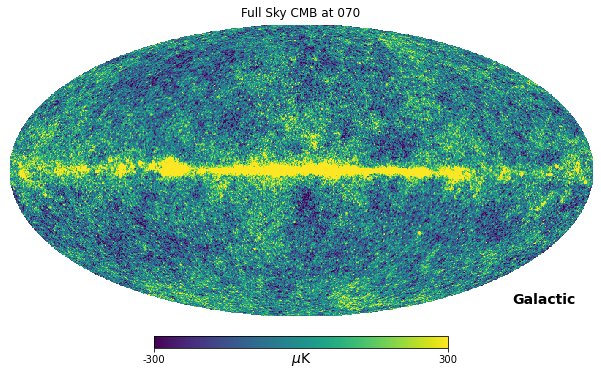

In [4]:
hp.mollview(
        original_healpix_map*1e6,
        coord=["G"],
        title="Full Sky CMB at "+frequency,
        unit=r"$\mu$K",
        min=-300, 
        max=300,
    )


In [5]:
# Step 2: Convert Healpix map to spherical harmonic coefficients
# convention: L_max = nside * 2
nside = hp.get_nside(original_healpix_map)
L_max = nside*2  # Define maximum multipole moment / detail level
hp_alm = hp.map2alm(original_healpix_map, lmax=L_max-1)
# lmax = L_max - 1 because python is 0-indexed

In [1]:
# Step 3: Rearrange coefficients for s2wav: from 1 dimensional to 2 dimensional
# s2fft only works with alm in 2d
# alm_2d = np.zeros((L_max, 2 * L_max - 1), dtype=np.complex128)

# for l in range(L_max):
#     for m in range(-l, l + 1):
#         index = hp.Alm.getidx(L_max - 1, l, abs(m))
#         if m < 0:
#             alm_2d[l, L_max + m - 1] = (-1)**m * np.conj(alm[index])
#         else:
#             alm_2d[l, L_max + m - 1] = alm[index]
# print(f"Shape of alm_2d: {alm_2d.shape}")


def hp_alm_2_mw_alm(hp_alm, lmax, Store=False, path=None):
    # Initialize the 2D MW_alm array with correct dimensions
    MW_alm = np.zeros((lmax, 2 * lmax + 1), dtype=np.complex128)

    for l in range(lmax):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax - 1, l, abs(m))
            if m < 0:
                MW_alm[l, lmax + m] = (-1)**m * np.conj(hp_alm[index])
            else:
                MW_alm[l, lmax + m] = hp_alm[index]

    # Optionally store the array
    if Store:
        if path is None:
            np.save("MW_alm.npy", MW_alm)
        else:
            np.save(path, MW_alm)
    
    return MW_alm

def mw_alm_2_hp_alm(MW_alm, lmax):
    # Initialize the 1D hp_alm array with the appropriate size
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
    
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]
    
    return hp_alm



In [7]:
mw_alm = hp_alm_2_mw_alm(hp_alm, L_max)
mw_alm.shape

(2048, 4097)

In [8]:
# Step 4: Apply s2fft to the 2d alm to get the map in MW sampling (2d)
original_MW_Map = s2fft.inverse(mw_alm, L_max)
np.save(f'../data/original_MW_map_{frequency}.npy', original_MW_Map)
stored_original_MW_map = np.load(f'../data/original_MW_map_{frequency}.npy')

In [15]:
original_MW_Map.shape

(2048, 4095)

In [10]:
# Step 5: Apply s2wav to the MW map to get the wavelet and scaling coefficients
N_directions = 1  # Number of directional wavelets
filter = filters.filters_directional_vectorised(L_max, N_directions)

wavelet_coeffs, scaling_coeffs = s2wav.analysis(stored_original_MW_map, L_max, N_directions, filters=filter,reality = False)

# Convert each element in f_wav to a numpy array and save it
for i, wav in enumerate(wavelet_coeffs):
    np_wav = np.array(wav)  # Convert JAX array to numpy array
    np.save(f"../convolution/wavelet_coefficient/wav_{frequency}_{i}", np_wav)  

# Convert  f_scal to a numpy array and save it
np_scal = np.array(scaling_coeffs)  # Convert JAX array to numpy array
np.save(f"../convolution/scaling_coefficient/scal_{frequency}", np_scal)  
stored_wavelet_coeffs = [np.load(f"../convolution/wavelet_coefficient/wav_{frequency}_{i}.npy", allow_pickle=True) for i in range(12)]
stored_scaling_coeffs = np.load(f"../convolution/scaling_coefficient/scal_{frequency}.npy")


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [14]:
!pip install jaxlib

Defaulting to user installation because normal site-packages is not writeable


In [14]:
filter1 = filters.filters_directional_vectorised(L_max+1, N_directions)
print(filter1[0].shape)
print(filter1[1].shape)

print(stored_wavelet_coeffs[0].shape)
s2fft.forward(stored_wavelet_coeffs[0], 4).shape

print(s2fft.forward())

(1, 4, 7)


(4, 7)

In [11]:
print(filter[0].shape)
print(filter[1].shape)

(12, 2048, 4095)
(2048,)


In [17]:
# Stored_original_MW_map = np.load(f'../data/MW_Map_{frequency}.npy')
# is_real = np.isreal(original_healpix_map)
# is_real = np.isreal(Stored_original_MW_map)
# print(is_real.all()) 
#  setting reality=True in the context of spherical harmonic analysis indicates that the input data is real-valued, and the function leverages the conjugate symmetry property of the harmonic coefficients to optimize storage and computation.

In [16]:
reconstructed_MW_map_raw = s2wav.synthesis(stored_wavelet_coeffs, stored_scaling_coeffs, L_max, N_directions, filters=filter, reality = False)

reconstructed_MW_map = np.array(reconstructed_MW_map_raw)
np.save(f"../convolution/reconstructed_MW_map_{frequency}", reconstructed_MW_map)  # Save numpy array to a file
stored_reconstructed_MW_map = np.load(f"../convolution/reconstructed_MW_map_{frequency}.npy")
reconstructed_MW_map_raw.shape

(2048, 4095)

In [ ]:
# print(f"Mean absolute error = {np.nanmean(np.abs(reconstructed_MW_map_raw - original_MW_Map))}")

In [21]:
print(f"Mean absolute error = {np.nanmean(np.abs(stored_reconstructed_MW_map - stored_original_MW_map))}")

Mean absolute error = 4.125169858376075e-15


(2048, 4095)

In [ ]:
# Step 2: Perform spherical harmonic transform using s2fft
alm_reconstructed_MW_map = s2fft.forward(stored_reconstructed_MW_map, L_max)


In [19]:
np.save(f'../data/alm_reconstructed_MW_map_{frequency}.npy', alm_reconstructed_MW_map)
stored_alm_reconstructed_MW_map = np.load(f'../data/alm_reconstructed_MW_map_{frequency}.npy')
stored_alm_reconstructed_MW_map.shape

(2048, 4095)

In [39]:
# Step 3: Rearrange coefficients for healpy
n_coeff = hp.Alm.getsize(L_max-1)
reconstructed_healpix_alm = np.zeros(n_coeff, dtype=np.complex128)

for l in range(L_max):
    for m in range(-l, l + 1):
        alm_index = hp.Alm.getidx(L_max - 1, l, abs(m))
        if alm_index >= n_coeff:
            print(f"Index {alm_index} is out of bounds for alm with size {n_coeff}")
            continue
        if m < 0:
            reconstructed_healpix_alm[alm_index] = (-1) ** m * np.conj(stored_alm_reconstructed_MW_map[l, L_max + m - 1])
        else:
            reconstructed_healpix_alm[alm_index] = stored_alm_reconstructed_MW_map[l, L_max + m - 1]


In [21]:
reconstructed_healpix_alm.shape

(2098176,)

In [23]:
lmax = L_max-1

In [24]:
MW_alm2 = stored_alm_reconstructed_MW_map.copy()

In [25]:
# Initialize the 1D hp_alm array with the appropriate size
hp_alm1 = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
    
for l in range(lmax + 1):
    for m in range(-l, l + 1):
        index = hp.Alm.getidx(lmax, l, abs(m))
        if m < 0:
            hp_alm1[index] = (-1)**m * np.conj(MW_alm2[l, lmax + m])
        else:
            hp_alm1[index] = MW_alm2[l, lmax + m]

hp_alm1.shape

(2098176,)

In [27]:
sum(hp_alm1 == reconstructed_healpix_alm)

2098176

In [40]:
# Now `alm` is ready to be used with healpy
nside = L_max // 2
healpix_map = hp.alm2map(reconstructed_healpix_alm, nside, verbose=False)
# healpix_map = hp.alm2map(hp_alm, nside, verbose=False)

# Save the HEALPix map to a FITS file
output_fits_path = f'reconstructed_healpix_map_{frequency}.fits'
hp.write_map(output_fits_path, healpix_map, overwrite=True, dtype=np.float64)

In [41]:
new_healpix_map = hp.read_map(output_fits_path)

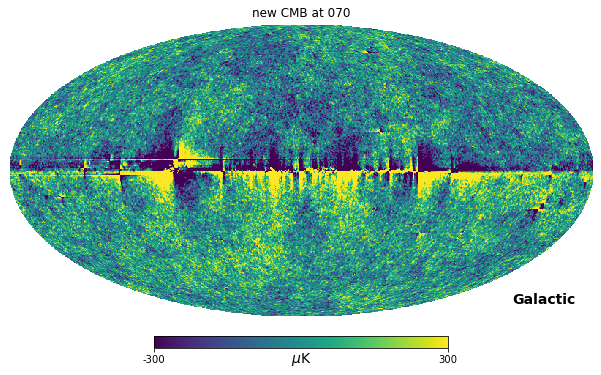

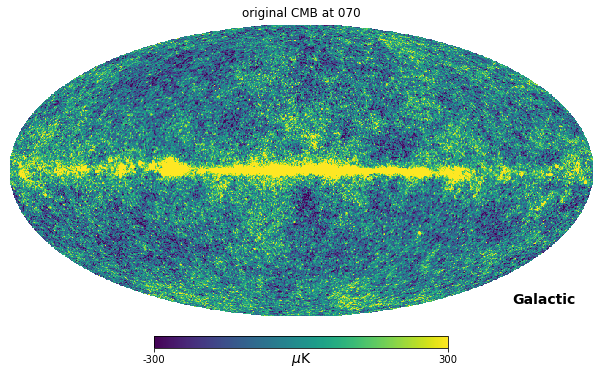

In [42]:

hp.mollview(
        new_healpix_map*1e6,
        coord=["G"],
        title="new CMB at "+frequency,
        unit=r"$\mu$K",
        min=-300, 
        max=300,
    )

hp.mollview(
        original_healpix_map*1e6,
        coord=["G"],
        title="original CMB at "+frequency,
        unit=r"$\mu$K",
        min=-300, 
        max=300,
    )

In [31]:
print(len(stored_wavelet_coeffs))

12


In [32]:
for i in range(len(stored_wavelet_coeffs)):
    print(f"Shape of wavelet_coeffs:{i} {stored_wavelet_coeffs[i].shape}")
# print(f"Shape of wavelet_coeffs: {stored_wavelet_coeffs[1].shape}")

Shape of wavelet_coeffs:0 (1, 4, 7)
Shape of wavelet_coeffs:1 (1, 4, 7)
Shape of wavelet_coeffs:2 (1, 8, 15)
Shape of wavelet_coeffs:3 (1, 16, 31)
Shape of wavelet_coeffs:4 (1, 32, 63)
Shape of wavelet_coeffs:5 (1, 64, 127)
Shape of wavelet_coeffs:6 (1, 128, 255)
Shape of wavelet_coeffs:7 (1, 256, 511)
Shape of wavelet_coeffs:8 (1, 512, 1023)
Shape of wavelet_coeffs:9 (1, 1024, 2047)
Shape of wavelet_coeffs:10 (1, 2048, 4095)
Shape of wavelet_coeffs:11 (1, 2048, 4095)


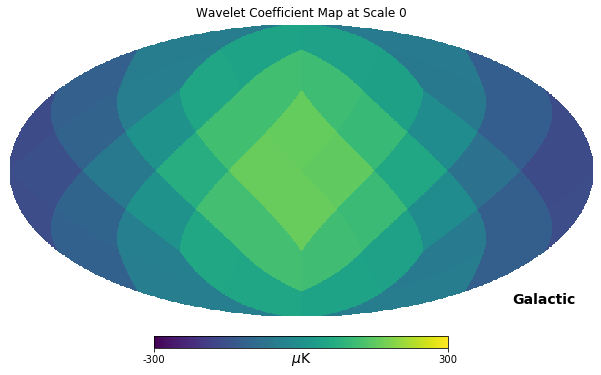

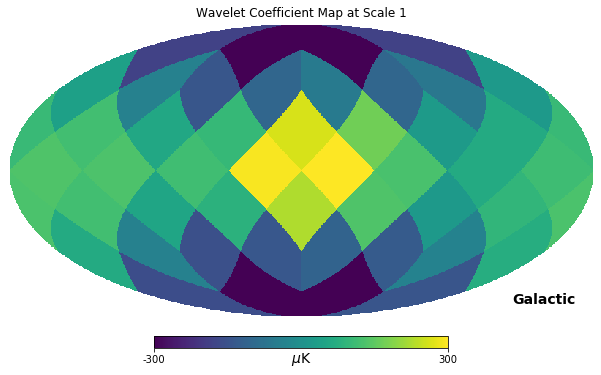

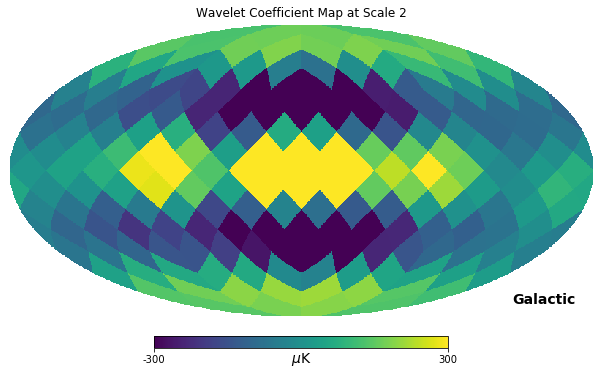

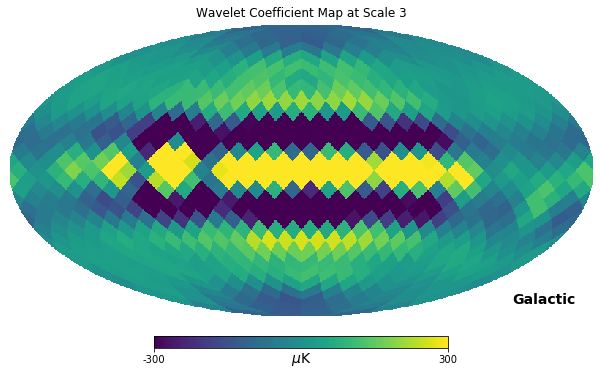

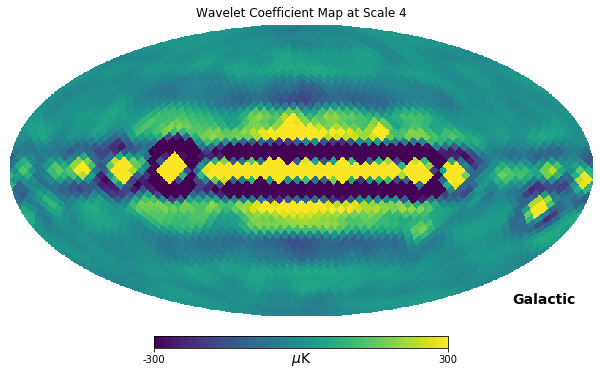

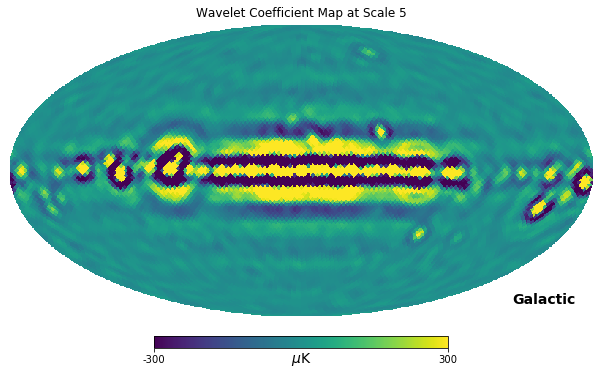

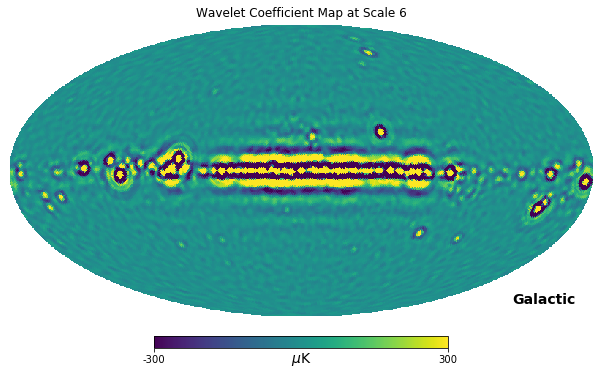

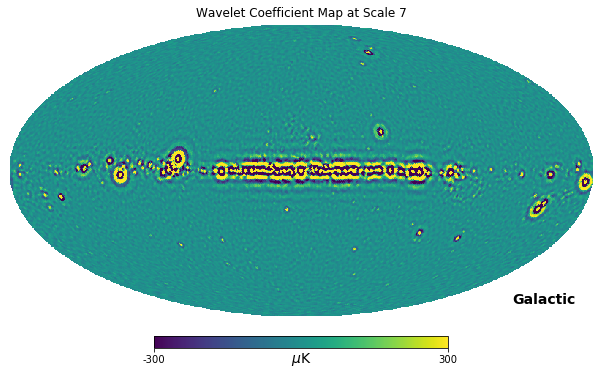

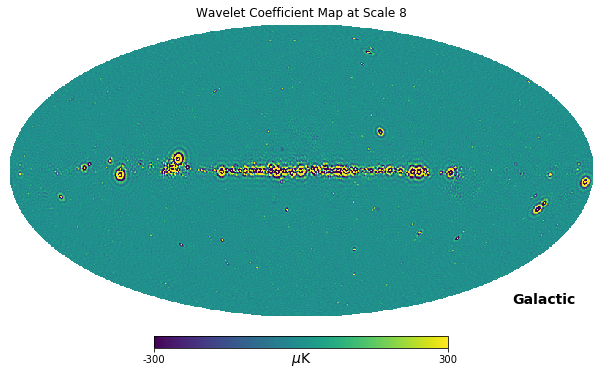

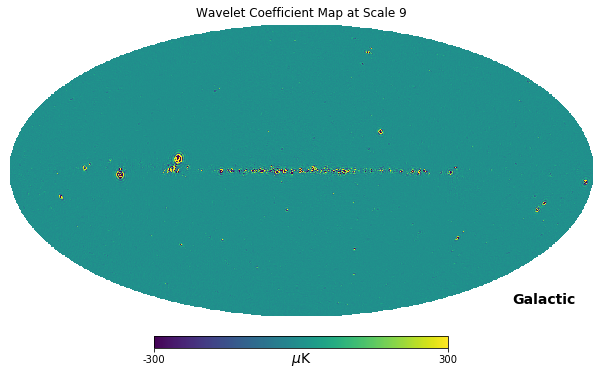

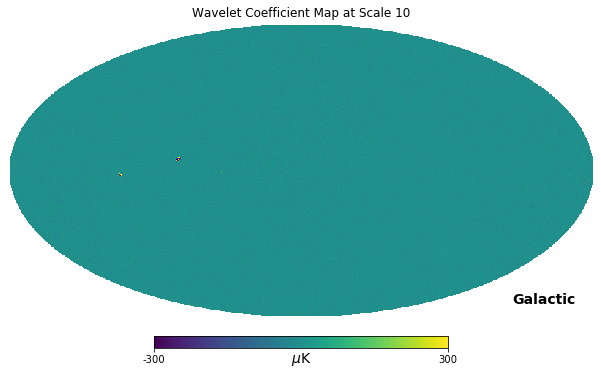

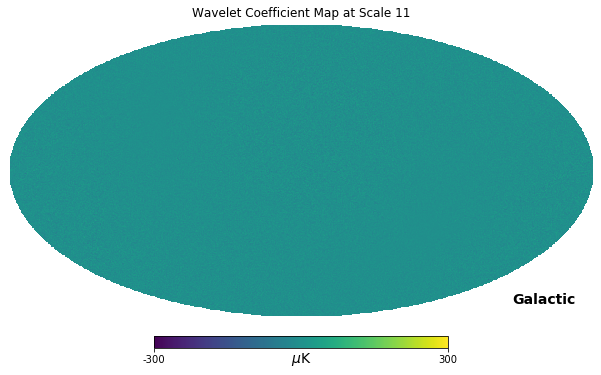

In [8]:
for i in range(12):
    # perform a forward transformation to convert 
    # the wavelet coefficients into the spherical harmonic alm space (2D).

    wavelet_in_alm = s2fft.forward(stored_wavelet_coeffs[i], L = stored_wavelet_coeffs[i].shape[1])
    alm_reconstructed_MW_map = wavelet_in_alm 
    L_max = stored_wavelet_coeffs[i].shape[1]
    np.save(f"../convolution/alm_reconstructed_MW_map_{i}_{frequency}", alm_reconstructed_MW_map)  # Save numpy array to a file
    
    #Rearrange coefficients for healpy (1D).
    n_coeff = hp.Alm.getsize(L_max-1)
    reconstructed_healpix_alm_1 = np.zeros(n_coeff, dtype=np.complex128)
    
    for l in range(L_max):
        for m in range(-l, l + 1):
            alm_index = hp.Alm.getidx(L_max - 1, l, abs(m))
            if alm_index >= n_coeff:
                print(f"Index {alm_index} is out of bounds for alm with size {n_coeff}")
                continue
            if m < 0:
                reconstructed_healpix_alm_1[alm_index] = (-1) ** m * np.conj(alm_reconstructed_MW_map[l, L_max + m - 1])
            else:
                reconstructed_healpix_alm_1[alm_index] = alm_reconstructed_MW_map[l, L_max + m - 1]
    
    # Use the alm2map function to convert them into a Healpix map.
    nside = L_max // 2
    wavelet_healpix_map = hp.alm2map(reconstructed_healpix_alm_1, nside, verbose=False)
    np.save(f"../convolution/wavelet_healpix_map_{i}_{frequency}",wavelet_healpix_map)  # Save numpy array to a file
    wavelet_scale = str(i)
    
    # Use hp.mollview to plot the wavelet coefficient map.

    hp.mollview(
            wavelet_healpix_map*1e6,
            coord=["G"],
            title="Wavelet Coefficient Map at Scale "+wavelet_scale,
            unit=r"$\mu$K",
            min=-300, 
            max=300,
        )



In [12]:
alm_reconstructed_MW_map = np.load(f"convolution/alm_reconstructed_MW_map_{1}.npy")


(4, 7)